In [1]:
import json
import plot_map
import geopandas
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

In [2]:
def od_visualization(od_df, bounds, path=False):
    '''od数据可视化'''
    fig  = plt.figure(figsize=(10, 8), dpi=250)
    ax = plt.subplot(111)
    plt.sca(ax)

    plot_map.plot_map(plt, bounds, zoom=10, style=4)

    gy.plot(ax=ax, edgecolor=(0,0,0,1), facecolor=(0,0,0,0), linewidth=0.5)

    vmax = od_df['人数'].max()
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    cmapname = 'autumn_r'
    cmap = mpl.cm.get_cmap(cmapname)

    dis_names = []
    for i in range(len(od_df)):
        color_i = cmap(norm(od_df['人数'].iloc[i]))
        linewidth_i = norm(od_df['人数'].iloc[i])*5

        plt.annotate('', xy = [od_df['终点区域经度'].iloc[i], od_df['终点区域纬度'].iloc[i]],
                    xytext = [od_df['起点区域经度'].iloc[i], od_df['起点区域纬度'].iloc[i]],
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=-0.3', color=color_i, lw=linewidth_i))


    for i, s in dis_gps.iterrows():
        plt.text(s['经度']-0.05, s['纬度'], s['区域'])


    plt.axis('off') # 不显示坐标轴

    plt.imshow([[0, vmax]], cmap=cmap)
    cax = plt.axes([0.23, 0.32, 0.02, 0.3])
    plt.colorbar(cax=cax)

    ax.set_xlim([bounds[0], bounds[2]])
    ax.set_ylim([bounds[1], bounds[3]])
    if path:
        plt.savefig(path, dpi=120)
    
    plt.show()

## 样例

In [3]:
def get_track(point, coords):
    '''判断某个gps点是否包含在电子围栏内， 返回True或False
       point为点坐标的类数组， 先经度， 后纬度；
       coords为电子围栏坐标的二维类数组， 先经度， 后纬度'''
    
    coords = np.concatenate([g[0] for g in coords]) # ['features'][0]['geometry']['coordinates']
    polygon = Polygon(np.array(coords).astype(float))
    point = Point(point[0], point[1])
    
    return polygon.contains(point)

In [4]:
def get_dis_name(lon_lat):
    '''根据gps点坐标获取区域名称'''
    state = 0
    for i in gy_geojson['features'][:]:
        dis_name = i['properties']['name']
        dis_gis = i['geometry']['coordinates']#[0][0]
        if get_track(lon_lat, dis_gis):
            state = 1
            break
    if state == 1:
        return dis_name

In [5]:
shp_path = r"C:\Users\zhangweijiang\Downloads\贵阳市.txt" # shp文件
json_path = r"C:\Users\zhangweijiang\Downloads\520100_full.json" # geojson文件
od_path = r"D:\数据集\6.1-6.27端午节\关键词提取&词性标注\od.xlsx" # od数据

In [6]:
with open(json_path, encoding='utf-8-sig') as f:
    gy_geojson = json.load(f)
    
gy = geopandas.GeoDataFrame.from_file(shp_path, encoding='utf-8')

In [7]:
dis_gps_list = []
for i in gy_geojson['features'][:]:
    dis_name = i['properties']['name']
    dis_gis = np.array(i['geometry']['coordinates'][0][0])
    dis_gps_list.append([dis_name, dis_gis[:,0].mean(), dis_gis[:,1].mean()])
    
dis_gps = pd.DataFrame(dis_gps_list, columns=['区域', '经度', '纬度'])

In [8]:
od = pd.read_excel(od_path)

In [9]:
def od_data_prerpocess(od_df, dis_gps):
    '''od数据预处理'''
    od_df = od_df.copy()
    od_df.loc[:, '起点区域'] = od_df['起点交通小区范围（边缘坐标)'].map(lambda x: [float(i) for i in x.split(';')[0].split(',')])
    od_df.loc[:, '终点区域'] = od_df['终点交通小区范围（边缘坐标)'].map(lambda x: [float(i) for i in x.split(';')[0].split(',')])

    od_df.loc[:, '起点区域'] = od_df['起点区域'].map(get_dis_name)
    od_df.loc[:, '终点区域'] = od_df['终点区域'].map(get_dis_name)

    od_df = od_df.query('起点区域 != 终点区域').copy()
    od_df.dropna(inplace=True)

    od_df_prepared = od_df.groupby(['起点区域', '终点区域'])['人数'].sum().reset_index()

    od_df_gps_prepared = pd.merge(od_df_prepared, dis_gps, left_on='起点区域', right_on='区域')
    od_df_gps_prepared.rename(columns={'经度': '起点区域经度', '纬度': '起点区域纬度'}, inplace=True)
    od_df_gps_prepared = pd.merge(od_df_gps_prepared, dis_gps, left_on='终点区域', right_on='区域')
    od_df_gps_prepared.rename(columns={'经度': '终点区域经度', '纬度': '终点区域纬度'}, inplace=True)
    
    return od_df_gps_prepared

In [10]:
od_morning = od_data_prerpocess(od.query('时段 in [7, 8, 9]'), dis_gps)

In [11]:
od_morning.sort_values(by='人数', ascending=False)

,起点区域,终点区域,人数,区域_x,起点区域经度,起点区域纬度,区域_y,终点区域经度,终点区域纬度
44,云岩区,观山湖区,6043,云岩区,106.690676,26.602580,观山湖区,106.556811,26.633276
2,南明区,云岩区,4061,南明区,106.784463,26.541133,云岩区,106.690676,26.602580
8,观山湖区,云岩区,3992,观山湖区,106.556811,26.633276,云岩区,106.690676,26.602580
38,南明区,花溪区,2383,南明区,106.784463,26.541133,花溪区,106.649725,26.383089
21,花溪区,南明区,2255,花溪区,106.649725,26.383089,南明区,106.784463,26.541133
...,...,...,...,...,...,...,...,...,...
18,开阳县,南明区,20,开阳县,107.055934,27.004180,南明区,106.784463,26.541133
23,乌当区,开阳县,19,乌当区,106.855965,26.730931,开阳县,107.055934,27.004180
58,云岩区,清镇市,14,云岩区,106.690676,26.602580,清镇市,106.406924,26.619229
34,云岩区,白云区,0,云岩区,106.690676,26.602580,白云区,106.672871,26.732042


In [12]:
res_path1 = r"D:\新建文件夹 (2)\WeChat Files\wxid_r5nb2w32sc5q12\FileStorage\File\2021-08\od_早高峰.xlsx"
od_morning.sort_values(by='人数', ascending=False).to_excel(res_path1, index=False, freeze_panes=[1,0])

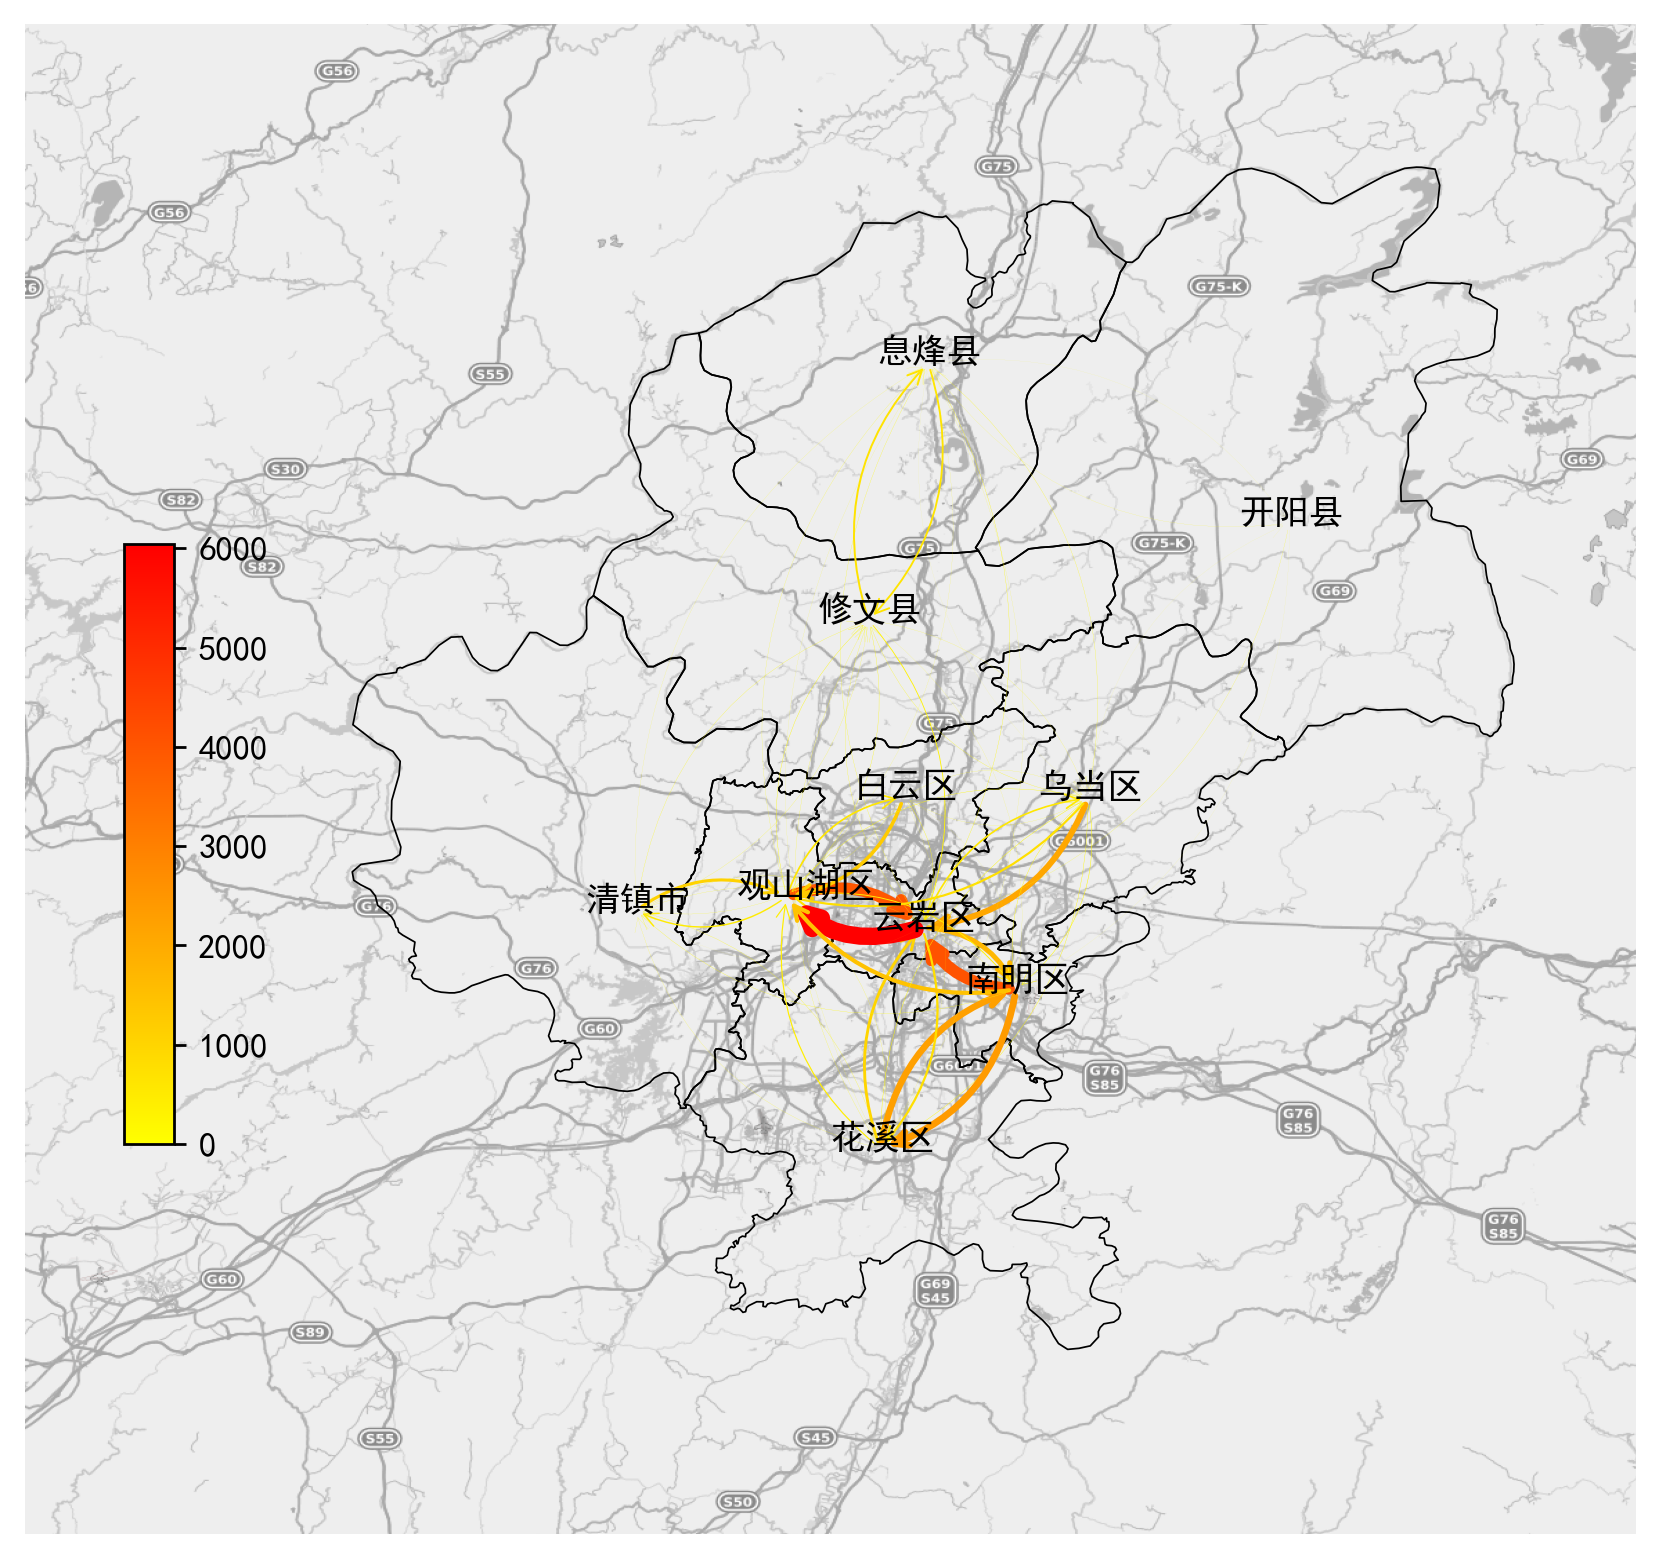

In [13]:
od_visualization(od_morning, [105.8, 26, 107.4,  27.5], 
                 path = r"D:\新建文件夹 (2)\WeChat Files\wxid_r5nb2w32sc5q12\FileStorage\File\2021-08\od可视化_早高峰.png")

In [14]:
od_afternoon = od_data_prerpocess(od.query('时段 in [16, 17, 18]'), dis_gps)

In [15]:
od_afternoon.sort_values(by='人数', ascending=False)

,起点区域,终点区域,人数,区域_x,起点区域经度,起点区域纬度,区域_y,终点区域经度,终点区域纬度
8,观山湖区,云岩区,6037,观山湖区,106.556811,26.633276,云岩区,106.690676,26.602580
22,花溪区,南明区,3297,花溪区,106.649725,26.383089,南明区,106.784463,26.541133
53,云岩区,观山湖区,3088,云岩区,106.690676,26.602580,观山湖区,106.556811,26.633276
2,南明区,云岩区,2642,南明区,106.784463,26.541133,云岩区,106.690676,26.602580
47,南明区,花溪区,2492,南明区,106.784463,26.541133,花溪区,106.649725,26.383089
...,...,...,...,...,...,...,...,...,...
24,乌当区,开阳县,19,乌当区,106.855965,26.730931,开阳县,107.055934,27.004180
48,息烽县,花溪区,16,息烽县,106.697185,27.163024,花溪区,106.649725,26.383089
38,白云区,清镇市,12,白云区,106.672871,26.732042,清镇市,106.406924,26.619229
56,开阳县,观山湖区,6,开阳县,107.055934,27.004180,观山湖区,106.556811,26.633276


In [16]:
res_path2 = r"D:\新建文件夹 (2)\WeChat Files\wxid_r5nb2w32sc5q12\FileStorage\File\2021-08\od_晚高峰.xlsx"
od_afternoon.sort_values(by='人数', ascending=False).to_excel(res_path2, index=False, freeze_panes=[1,0])

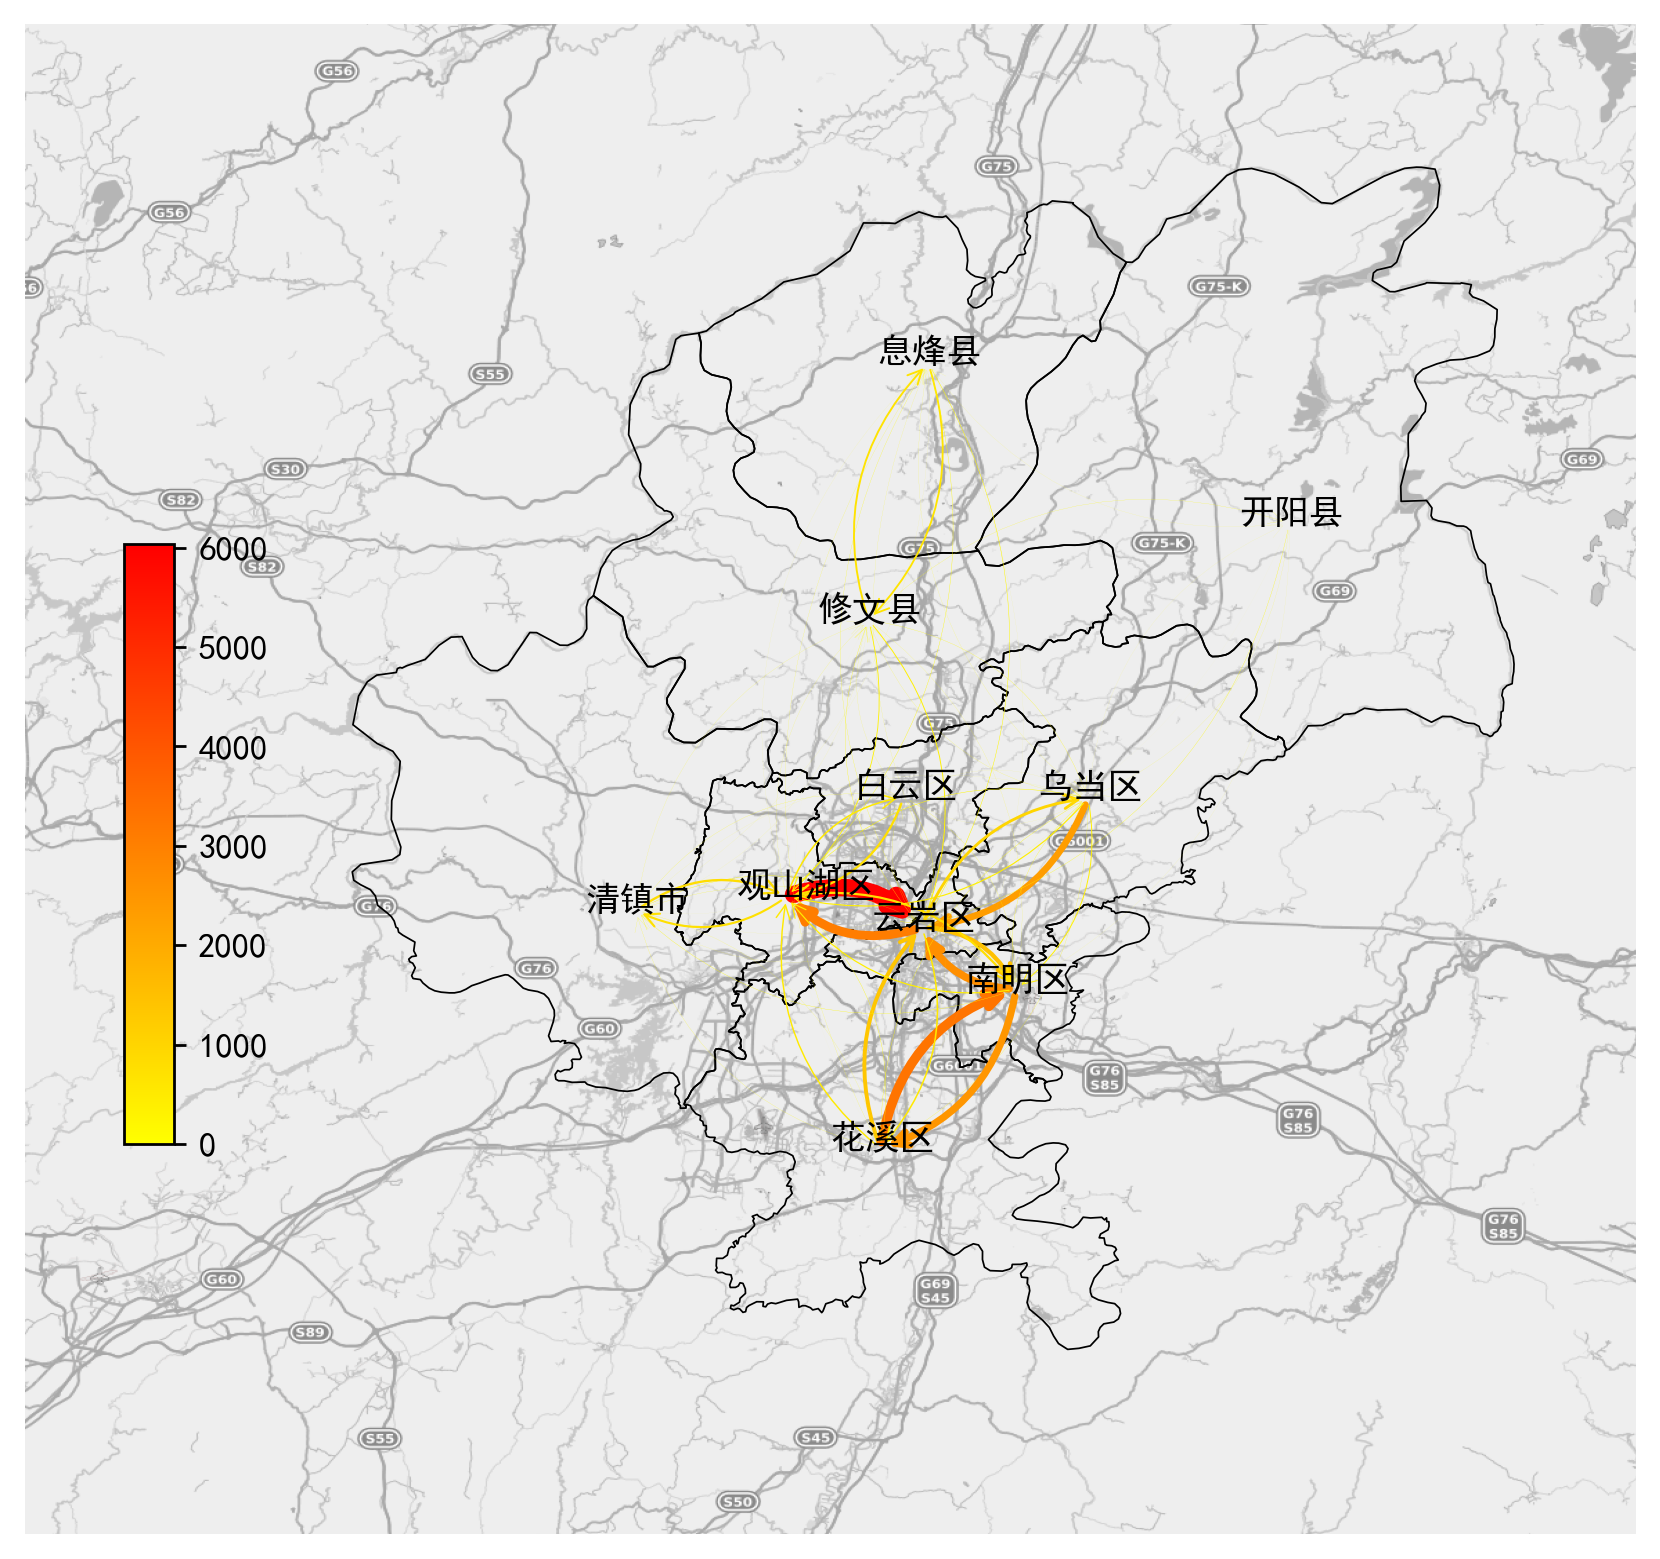

In [17]:
od_visualization(od_afternoon, [105.8, 26, 107.4,  27.5], 
                 path = r"D:\新建文件夹 (2)\WeChat Files\wxid_r5nb2w32sc5q12\FileStorage\File\2021-08\od可视化_晚高峰.png")